In [3]:
import os
import polars as pl
import pandas as pd
from models import model_prep_on_base
from models import create_model_pipeline
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score

In [4]:

# Load data
on_base_path = "../data/throw_home_runner_on_third_wide_sprint_arm.parquet"
on_base_lf = pl.scan_parquet(on_base_path)

# Feature column names
responses = ["is_out"]

num_predictors_drop = [
    "distance_catch_to_home"
]

num_predictors_median = [
]

# Parameter grid
param_grid = {
    'classifier__penalty': ['elasticnet'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'classifier__solver': ['saga'],
    'classifier__max_iter': [100, 250, 500, 1000]
}

# Scoring method
specificity_scorer = make_scorer(recall_score, pos_label=1)
precision_pos_scorer = make_scorer(precision_score, pos_label=1, zero_division=0)
f1_pos_scorer = make_scorer(f1_score, pos_label=1, zero_division=0)
scoring = {
    'log_loss': 'neg_log_loss',
    'brier_score': 'neg_brier_score'
}
refit = "brier_score"



# Train model
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="LogisticRegression",
    oversampling_method="SMOTE",
    param_grid=param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

grid_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_drop',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['distance_catch_to_home'])])),
                                       ('oversampler', SMOTE(random_state=123)),
                                       ('classifier',
                                        LogisticRegression(random_state=123))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'classifier__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
                         'classifier__max_iter': [100, 250, 500, 1000],
                         'classifier__penalty': ['elasticnet'],
                         'classifier__solver': ['saga']},
             refit='brier_score',
             scoring={'brier_score': 'neg_brier_score',
                      'log_loss': 'neg_log_loss'},
             verbose=1)

In [5]:
# Unmodified Train and Unmodified Test
umod_umod_results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = False,
    test_stay_to_out = False,
    test_stay_to_out_threshold = False,
)
umod_umod_results["y_test"].sum()


Total features: 2
Total Predictors: 1
Total Responses: 1
Fitting 5 folds for each of 120 candidates, totalling 600 fits

Best parameters: 
classifier__C = 100
classifier__l1_ratio = 0.9
classifier__max_iter = 100
classifier__penalty = elasticnet
classifier__solver = saga

Best cross-validation score: -0.1208

              precision    recall  f1-score   support

       False       1.00      0.83      0.91      1450
        True       0.13      0.86      0.22        42

    accuracy                           0.83      1492
   macro avg       0.56      0.84      0.57      1492
weighted avg       0.97      0.83      0.89      1492

Brier Score: 0.1195
log loss: 0.3822

Predictors:
distance_catch_to_home

Response:
is_out


np.int64(42)

In [6]:
# Censored Train and Unmodified Test
censored_umod_results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = True,
    test_stay_to_out = False,
    test_stay_to_out_threshold = False,
)
censored_umod_results["y_test"].sum()

Total features: 2
Total Predictors: 1
Total Responses: 1
Fitting 5 folds for each of 120 candidates, totalling 600 fits

Best parameters: 
classifier__C = 10
classifier__l1_ratio = 0.5
classifier__max_iter = 100
classifier__penalty = elasticnet
classifier__solver = saga

Best cross-validation score: -0.0535

              precision    recall  f1-score   support

       False       0.99      0.92      0.95      1450
        True       0.17      0.60      0.27        42

    accuracy                           0.91      1492
   macro avg       0.58      0.76      0.61      1492
weighted avg       0.96      0.91      0.93      1492

Brier Score: 0.0658
log loss: 0.2251

Predictors:
distance_catch_to_home

Response:
is_out


np.int64(42)

In [7]:
# Censored Train and Censored Test
censored_censored_results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = True,
    test_stay_to_out = False,
    test_stay_to_out_threshold = True,
)
censored_censored_results["y_test"].sum()
censored_censored_results['pipeline']

Total features: 2
Total Predictors: 1
Total Responses: 1
Fitting 5 folds for each of 120 candidates, totalling 600 fits

Best parameters: 
classifier__C = 10
classifier__l1_ratio = 0.5
classifier__max_iter = 100
classifier__penalty = elasticnet
classifier__solver = saga

Best cross-validation score: -0.0535

              precision    recall  f1-score   support

       False       0.99      0.92      0.95      1450
        True       0.72      0.95      0.82       323

    accuracy                           0.92      1773
   macro avg       0.85      0.93      0.88      1773
weighted avg       0.94      0.92      0.93      1773

Brier Score: 0.0568
log loss: 0.1986

Predictors:
distance_catch_to_home

Response:
is_out


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_drop',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['distance_catch_to_home'])])),
                ('oversampler', SMOTE(random_state=123)),
                ('classifier',
                 LogisticRegression(C=10, l1_ratio=0.5, penalty='elasticnet',
                                    random_state=123, solver='saga'))])

In [8]:
# Censored Train and Converted Stay to Out Test
censored_converted_results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = True,
    test_stay_to_out = True,
    test_stay_to_out_threshold = False,
)
censored_converted_results["y_test"].sum()

Total features: 2
Total Predictors: 1
Total Responses: 1
Fitting 5 folds for each of 120 candidates, totalling 600 fits

Best parameters: 
classifier__C = 10
classifier__l1_ratio = 0.5
classifier__max_iter = 100
classifier__penalty = elasticnet
classifier__solver = saga

Best cross-validation score: -0.0535

              precision    recall  f1-score   support

       False       0.94      0.92      0.93      1450
        True       0.73      0.81      0.77       408

    accuracy                           0.89      1858
   macro avg       0.84      0.86      0.85      1858
weighted avg       0.90      0.89      0.89      1858

Brier Score: 0.0759
log loss: 0.2508

Predictors:
distance_catch_to_home

Response:
is_out


np.int64(408)

In [9]:
# Converted Stay to Out Test Train and Converted Stay to Out Test
responses = ["is_successful"]

converted_converted_results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = False,
    test_stay_to_out = False,
    test_stay_to_out_threshold = False,
)
(converted_converted_results["y_test"] == False).sum()

Total features: 2
Total Predictors: 1
Total Responses: 1
Fitting 5 folds for each of 120 candidates, totalling 600 fits

Best parameters: 
classifier__C = 1
classifier__l1_ratio = 0.5
classifier__max_iter = 100
classifier__penalty = elasticnet
classifier__solver = saga

Best cross-validation score: -0.0800

              precision    recall  f1-score   support

       False       0.67      0.89      0.76       411
        True       0.97      0.88      0.92      1448

    accuracy                           0.88      1859
   macro avg       0.82      0.88      0.84      1859
weighted avg       0.90      0.88      0.88      1859

Brier Score: 0.0860
log loss: 0.2727

Predictors:
distance_catch_to_home

Response:
is_successful


np.int64(411)

In [10]:
# Feature column names
responses = ["is_out"]

num_predictors_drop = [
    "hang_time",
  "distance_catch_to_home",
  "distance_traveled_fielder",
  "distance_traveled_all_fielders",
  "distance_to_home_diff",
  "distance_catch_to_first",
  "distance_catch_to_second",
  "distance_catch_to_third",

]

num_predictors_median = [
      "seconds_since_hit_085_mlb_person_id_R3",
  "arm_overall_fielder_mlb_person_id",
]

# Train model
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="LogisticRegression",
    oversampling_method="SMOTE",
    param_grid=param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

grid_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_drop',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['hang_time',
                                                                          'distance_catch_to_home',
                                                                          'distance_traveled_fielder',
                                                                          'distance_traveled_all_fielders',
                                                                          'distance_to_home_diff',
                                                                          'distance_catch_to_first',
                                                                          'distance_catch_to_second',
                                                                          'distance_catch_to_third...
                                        LogisticRegression(random_state=123))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'classifier__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
                         'classifier__max_iter': [100, 250, 500, 1000],
                         'classifier__penalty': ['elasticnet'],
                         'classifier__solver': ['saga']},
             refit='brier_score',
             scoring={'brier_score': 'neg_brier_score',
                      'log_loss': 'neg_log_loss'},
             verbose=1)

In [11]:
# Unmodified Train and Unmodified Test
umod_umod_full_mod_results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = False,
    test_stay_to_out = False,
    test_stay_to_out_threshold = False,
)
umod_umod_full_mod_results["y_test"].sum()
umod_umod_full_mod_results["pipeline"]

Total features: 11
Total Predictors: 10
Total Responses: 1
Fitting 5 folds for each of 120 candidates, totalling 600 fits


/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reac


Best parameters: 
classifier__C = 100
classifier__l1_ratio = 0.9
classifier__max_iter = 1000
classifier__penalty = elasticnet
classifier__solver = saga

Best cross-validation score: -0.1001

              precision    recall  f1-score   support

       False       0.99      0.87      0.93      1444
        True       0.15      0.81      0.26        42

    accuracy                           0.87      1486
   macro avg       0.57      0.84      0.59      1486
weighted avg       0.97      0.87      0.91      1486

Brier Score: 0.0988
log loss: 0.3322

Predictors:
hang_time
distance_catch_to_home
distance_traveled_fielder
distance_traveled_all_fielders
distance_to_home_diff
distance_catch_to_first
distance_catch_to_second
distance_catch_to_third
seconds_since_hit_085_mlb_person_id_R3
arm_overall_fielder_mlb_person_id

Response:
is_out


/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_drop',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['hang_time',
                                                   'distance_catch_to_home',
                                                   'distance_traveled_fielder',
                                                   'distance_traveled_all_fielders',
                                                   'distance_to_home_diff',
                                                   'distance_catch_to_first',
                                                   'distance_catch_to_second',
                                                   'distance_catch_to_third']),
                                                 ('num_median',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['seconds_since_hit_085_mlb_person_id_R3',
                                                   'arm_overall_fielder_mlb_person_id'])])),
                ('oversampler', SMOTE(random_state=123)),
                ('classifier',
                 LogisticRegression(C=100, l1_ratio=0.9, max_iter=1000,
                                    penalty='elasticnet', random_state=123,
                                    solver='saga'))])

Permutation Feature Importance:
                                  Feature  Importance       Std
4                   distance_to_home_diff   -0.048318  0.003996
5                 distance_catch_to_first   -0.025942  0.004827
7                 distance_catch_to_third   -0.019650  0.005310
6                distance_catch_to_second   -0.017093  0.002364
1                  distance_catch_to_home   -0.009287  0.001629
2               distance_traveled_fielder   -0.000538  0.000989
0                               hang_time   -0.000135  0.000693
3          distance_traveled_all_fielders    0.000269  0.003427
8  seconds_since_hit_085_mlb_person_id_R3    0.003365  0.003438
9       arm_overall_fielder_mlb_person_id    0.006090  0.002983


Text(0.5, 0, 'Mean decrease in accuracy')

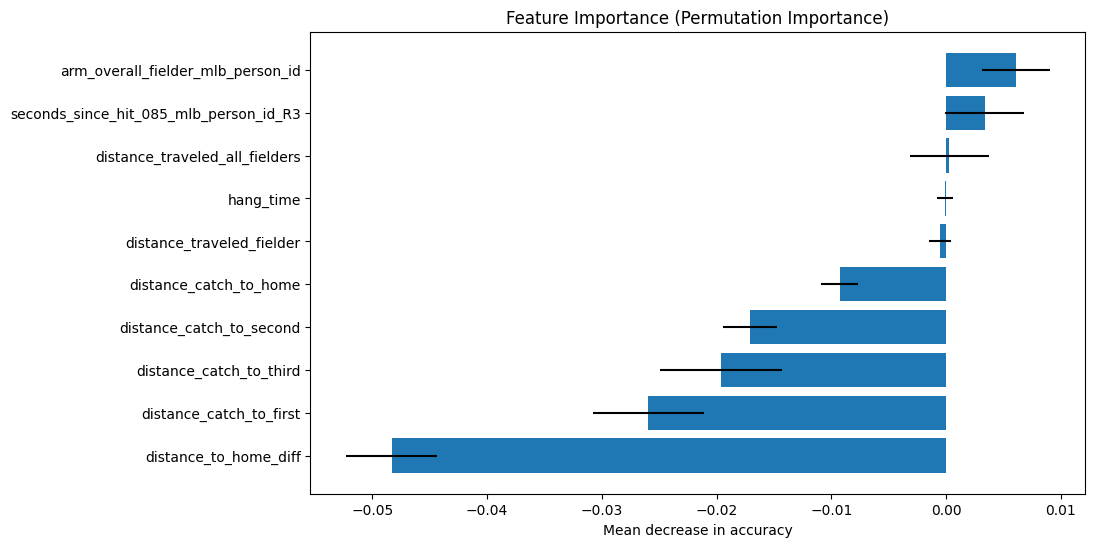

In [12]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

pipeline = umod_umod_full_mod_results["pipeline"]
X_test =   umod_umod_full_mod_results["X_test"]
y_test =   umod_umod_full_mod_results["y_test"]
features = umod_umod_full_mod_results["feature_names"]

# Permutation importance
result = permutation_importance(
    pipeline, X_test, y_test, n_repeats=20, random_state=123, n_jobs=-1
)

# Create a dataframe of feature importance
feature_names = list(features)
perm_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result.importances_mean,
    'Std': result.importances_std,
}).sort_values('Importance', ascending=True)

print("Permutation Feature Importance:")
print(perm_importance)

# Plot Permutation Importance
plt.figure(figsize=(10, 6))
plt.barh(perm_importance['Feature'], perm_importance['Importance'], 
         xerr=perm_importance['Std'])
plt.title('Feature Importance (Permutation Importance)')
plt.xlabel('Mean decrease in accuracy')

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(distance, y_pred_proba, alpha=0.6, s=30)
plt.xlabel('Distance')
plt.ylabel('Predicted Probability')
plt.title('Predicted Probabilities vs Distance')
plt.grid(True, alpha=0.3)
plt.show()

NameError: name 'distance' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
pipeline = umod_umod_full_mod_results["pipeline"]
X_test =   umod_umod_full_mod_results["X_test"]
y_test =   umod_umod_full_mod_results["y_test"]
features = umod_umod_full_mod_results["feature_names"]